In [13]:
%load_ext autoreload
%autoreload 2
%timeit


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from lanmm_helpers import plot_synaptic_filter 

In [15]:
from lanmmv11 import get_intrinsic_params
params = get_intrinsic_params()
params

{'A_AMPA': 3.25,
 'a_AMPA': 100.0,
 'A_GABA_slow': -22.0,
 'a_GABA_slow': 50.0,
 'A_GABA_fast': -30.0,
 'a_GABA_fast': 220.0,
 'C_vals': {1: 108.0,
  2: 33.7,
  3: 1.0,
  4: 135.0,
  5: 33.75,
  6: 70.0,
  7: 550.0,
  8: 1.0,
  9: 200.0,
  10: 100.0,
  11: 80.0,
  12: 200.0,
  13: 30.0,
  14: 1.0},
 'syn_types': {1: 'AMPA',
  2: 'GABA_slow',
  3: 'AMPA',
  4: 'AMPA',
  5: 'AMPA',
  6: 'AMPA',
  7: 'GABA_fast',
  8: 'AMPA',
  9: 'AMPA',
  10: 'GABA_fast',
  11: 'AMPA',
  12: 'AMPA',
  13: 'AMPA',
  14: 'AMPA'},
 'v0_default': 6.0,
 'v0_p2': 1.0,
 'fmax': 5.0,
 'r_slope': 0.56,
 'include_PV_drive': True}

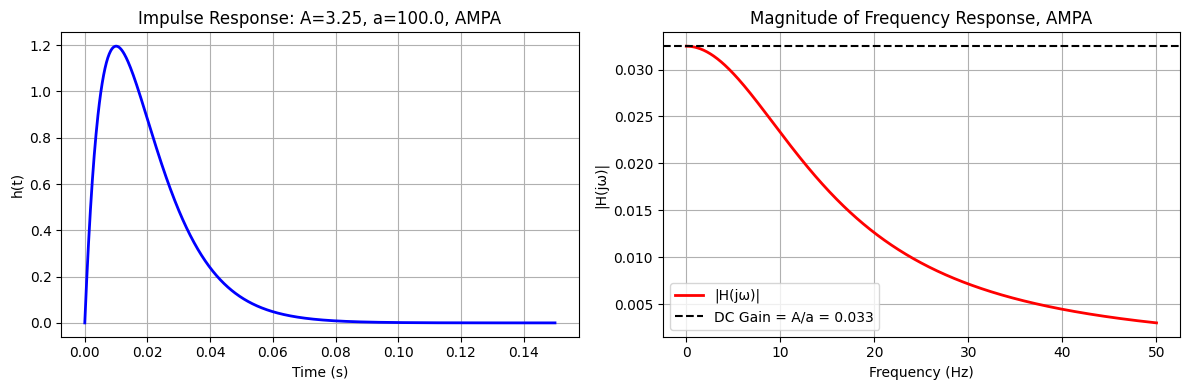

In [18]:
plot_synaptic_filter(A=params['A_AMPA'], a=params['a_AMPA'], 
                         tmax=0.15, nt=1000, 
                         fmax=50.0, nf=1000, title='AMPA')


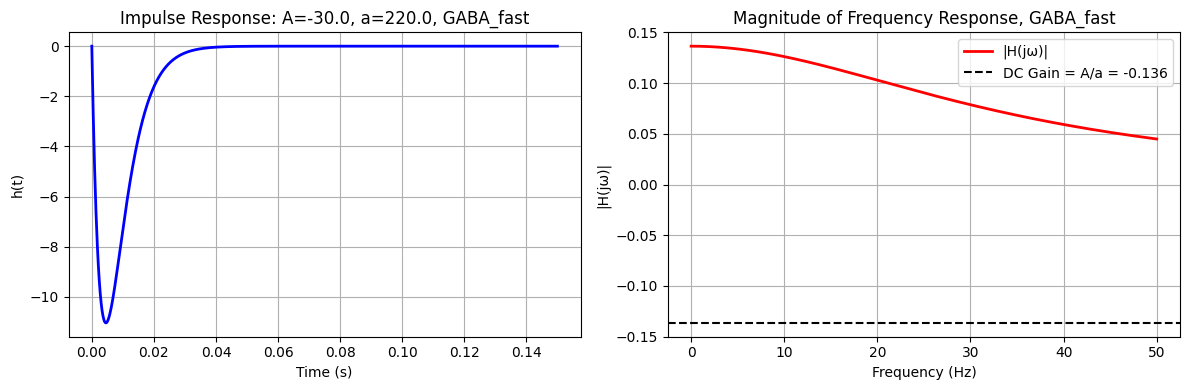

In [20]:
plot_synaptic_filter(A=params['A_GABA_fast'], a=params['a_GABA_fast'], title ='GABA_fast',
                         tmax=0.15, nt=1000, 
                         fmax=50.0, nf=1000)

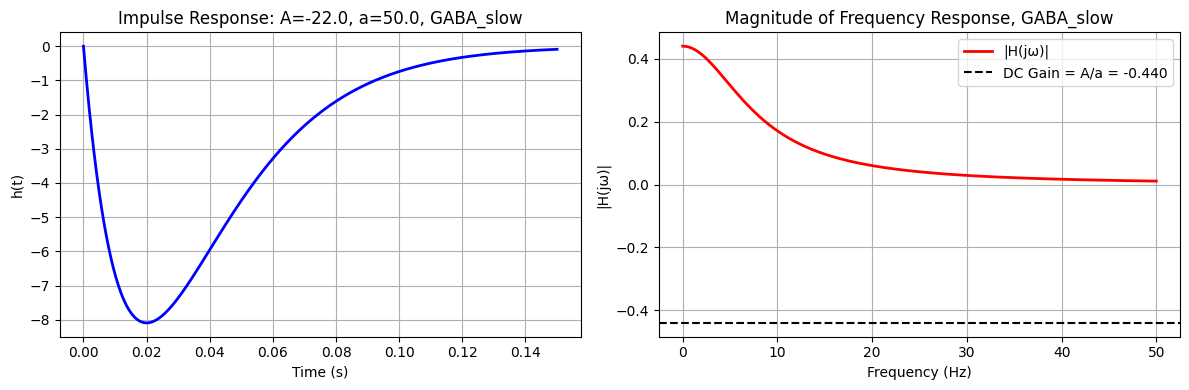

In [21]:
plot_synaptic_filter(A=params['A_GABA_slow'], a=params['a_GABA_slow'], title ='GABA_slow',
                         tmax=0.15, nt=1000, 
                         fmax=50.0, nf=1000)

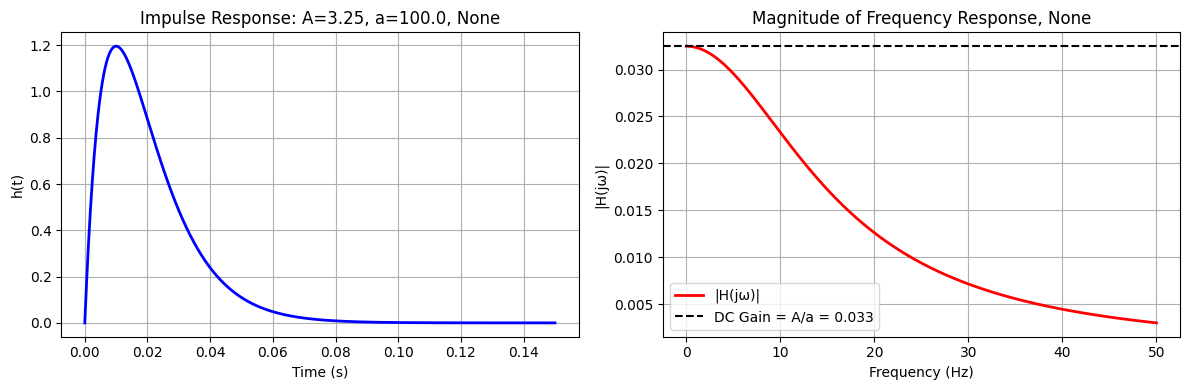

In [22]:

import numpy as np
import matplotlib.pyplot as plt
from lanmmv11 import run_unified_simulation
from lanmm_analyzer import plot_sim_results
from lanmmv11 import run_parameter_sweep
from lanmm_analyzer import (analyze_sweep_couplings, analyze_sweep_power, 
                            plot_coupling_heatmaps, plot_power_heatmaps_bottom_cbar, 
                            sweep_peix, plot_peix_heatmaps, 
                            analyze_peak_frequencies, plot_frequency_heatmaps)    
from lanmmv11 import generate_multiscale_noise, generate_nested_am_signal 
import os
import json
from datetime import datetime
import pickle   



def impulse_response(t, A, a):
    """
    Synaptic impulse response:
      h(t) = A * a * t * exp(-a t),  t >= 0
    """
    # For t < 0, the response is zero (we assume t >= 0 in the caller).
    return A * a * t * np.exp(-a * t)

def frequency_response(omega, A, a):
    """
    Frequency response in the jω-domain:
      H(jω) = A a / (a + j ω)^2
    Returns the magnitude |H(jω)|.
    """
    H = A*a / (a + 1j*omega)**2
    return np.abs(H)


def plot_synaptic_filter(A=3.25, a=100.0, 
                         tmax=0.1, nt=1000, 
                         fmax=50.0, nf=1000, title=None):
    """
    Plots the synaptic filter's impulse response h(t) and
    the magnitude of its frequency response |H(jω)| in Hz.

    Parameters
    ----------
    A : float
        Synaptic gain parameter.
    a : float
        Time constant parameter in 1/s (so 1/a is the main timescale).
    tmax : float
        Max time (s) for plotting the impulse response.
    nt : int
        Number of time samples in [0, tmax].
    fmax : float
        Max frequency (Hz) for plotting the frequency response.
    nf : int
        Number of frequency samples in [0, fmax].
    """
    # 1) Time domain
    t = np.linspace(0, tmax, nt)
    h_t = impulse_response(t, A, a)

    # 2) Frequency domain in Hz
    freq = np.linspace(0, fmax, nf)  # in Hz
    omega = 2.0 * np.pi * freq       # convert Hz to rad/s
    H_omega = frequency_response(omega, A, a)

    # DC gain for reference (|H(0)| = A/a).
    dc_gain = A / a

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # --- Plot impulse response ---
    axs[0].plot(t, h_t, 'b', linewidth=2)
    axs[0].set_title(f"Impulse Response: A={A}, a={a}, {title}")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("h(t)")
    axs[0].grid(True)

    # --- Plot frequency response (magnitude) in Hz ---
    axs[1].plot(freq, H_omega, 'r', linewidth=2, label='|H(jω)|')
    axs[1].axhline(dc_gain, color='k', linestyle='--', 
                   label=f"DC Gain = A/a = {dc_gain:.3f}")
    axs[1].set_title(f"Magnitude of Frequency Response, {title}")
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("|H(jω)|")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


            
   
# Example usage
if __name__ == "__main__":
    plot_synaptic_filter(A=3.25, a=100.0, 
                         tmax=0.15, nt=1000, 
                         fmax=50.0, nf=1000)


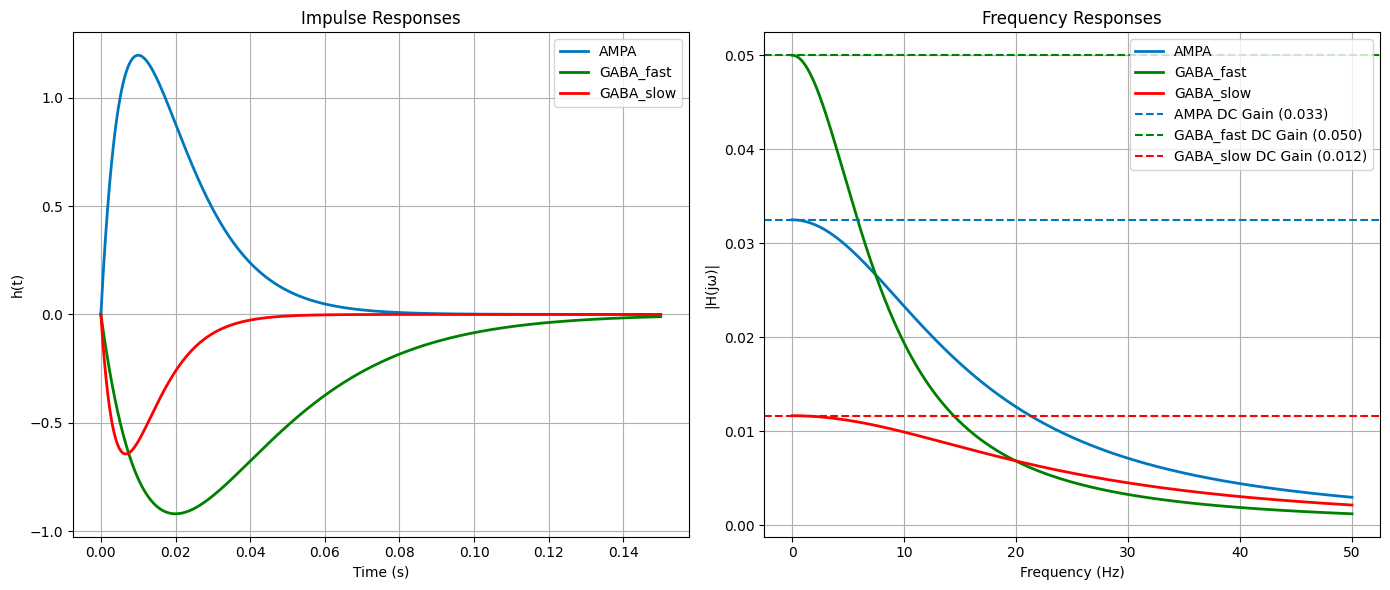

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def impulse_response(t, A, a):
    """
    Synaptic impulse response:
      h(t) = A * a * t * exp(-a * t), for t >= 0
    """
    return A * a * t * np.exp(-a * t)

def frequency_response(omega, A, a):
    """
    Frequency response in the jω-domain:
      H(jω) = A * a / (a + jω)^2
    Returns the magnitude |H(jω)|.
    """
    H = A * a / (a + 1j * omega)**2
    return np.abs(H)

# Define synaptic parameters
params = {
    'A_AMPA': 3.25, 'a_AMPA': 100.0,
    'A_GABA_fast': 2.50, 'a_GABA_fast': 50.0,
    'A_GABA_slow': 1.75, 'a_GABA_slow': 150.0
}

# Define colors for each channel
colors = {
    'AMPA': '#0077be',       # oceanblue
    'GABA_fast': 'green',     # green
    'GABA_slow': 'red'        # red
}

# Time and frequency settings
tmax, nt = 0.15, 1000
t = np.linspace(0, tmax, nt)

fmax, nf = 50.0, 1000
freq = np.linspace(0, fmax, nf)
omega = 2 * np.pi * freq

# Create a figure with two subplots (impulse and frequency responses)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Compute and plot impulse responses
h_AMPA = impulse_response(t, params['A_AMPA'], params['a_AMPA'])
h_GABA_fast = impulse_response(t, params['A_GABA_fast'], params['a_GABA_fast'])
h_GABA_slow = impulse_response(t, params['A_GABA_slow'], params['a_GABA_slow'])

axs[0].plot(t, h_AMPA, color=colors['AMPA'], linewidth=2, label='AMPA')
axs[0].plot(t, - h_GABA_fast, color=colors['GABA_fast'], linewidth=2, label='GABA_fast')
axs[0].plot(t, - h_GABA_slow, color=colors['GABA_slow'], linewidth=2, label='GABA_slow')

axs[0].set_title("Impulse Responses")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("h(t)")
axs[0].legend()
axs[0].grid(True)

# Compute and plot frequency responses
H_AMPA = frequency_response(omega, params['A_AMPA'], params['a_AMPA'])
H_GABA_fast = frequency_response(omega, params['A_GABA_fast'], params['a_GABA_fast'])
H_GABA_slow = frequency_response(omega, params['A_GABA_slow'], params['a_GABA_slow'])

axs[1].plot(freq, H_AMPA, color=colors['AMPA'], linewidth=2, label='AMPA')
axs[1].plot(freq, H_GABA_fast, color=colors['GABA_fast'], linewidth=2, label='GABA_fast')
axs[1].plot(freq, H_GABA_slow, color=colors['GABA_slow'], linewidth=2, label='GABA_slow')

# Plot DC gains as horizontal dashed lines
dc_gain_AMPA = params['A_AMPA'] / params['a_AMPA']
dc_gain_GABA_fast = params['A_GABA_fast'] / params['a_GABA_fast']
dc_gain_GABA_slow = params['A_GABA_slow'] / params['a_GABA_slow']

axs[1].axhline(dc_gain_AMPA, color=colors['AMPA'], linestyle='--',
               label=f'AMPA DC Gain ({dc_gain_AMPA:.3f})')
axs[1].axhline(dc_gain_GABA_fast, color=colors['GABA_fast'], linestyle='--',
               label=f'GABA_fast DC Gain ({dc_gain_GABA_fast:.3f})')
axs[1].axhline(dc_gain_GABA_slow, color=colors['GABA_slow'], linestyle='--',
               label=f'GABA_slow DC Gain ({dc_gain_GABA_slow:.3f})')

axs[1].set_title("Frequency Responses")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("|H(jω)|")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("synaptic_filters.png", dpi=300)

plt.show()

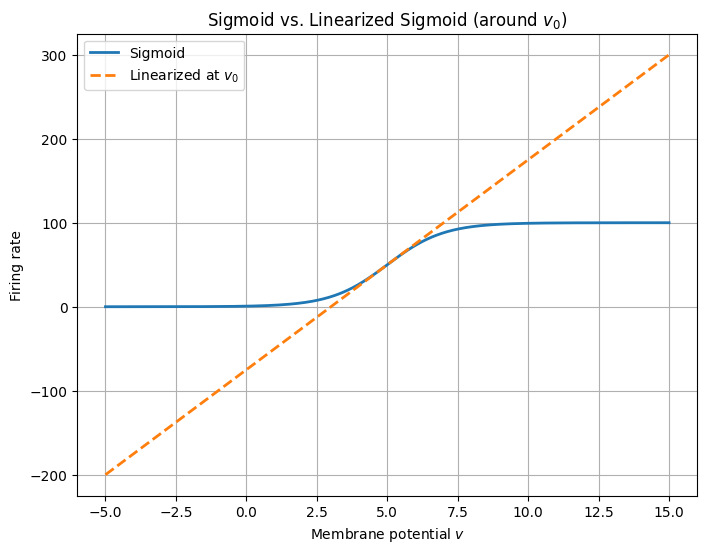

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def get_intrinsic_params():
    # Example parameters; adjust these as needed.
    return {
        'v0_default': 5.0,  # inflection point for 'default' population
        'v0_p2': 7.0,       # inflection point for 'P2' population
        'fmax': 100.0,      # maximum firing rate
        'r_slope': 1.0      # slope parameter
    }

def sigmoid_pop(v, pop='default', params=None):
    """
    Computes the firing rate from membrane potential using a sigmoid function.
    """
    if params is None:
        params = get_intrinsic_params()
    v0 = params['v0_p2'] if pop == 'P2' else params['v0_default']
    fmax = params['fmax']
    r = params['r_slope']
    return fmax / (1.0 + np.exp(r * (v0 - v)))

def sigmoid_pop_linear(v, pop='default', params=None):
    """
    Linearized version of the sigmoid around its inflection point (v = v0).
    f(v) ≈ f(v0) + f'(v0) (v - v0)
    where f(v0) = fmax/2 and f'(v0) = fmax*r/4.
    """
    if params is None:
        params = get_intrinsic_params()
    v0 = params['v0_p2'] if pop == 'P2' else params['v0_default']
    fmax = params['fmax']
    r = params['r_slope']
    
    f_v0 = fmax / 2.0
    df_dv_v0 = fmax * r / 4.0
    
    return f_v0 + df_dv_v0 * (v - v0)

# Generate a range of membrane potential values centered around v0
params = get_intrinsic_params()
v0 = params['v0_default']
v_vals = np.linspace(v0 - 10, v0 + 10, 500)

# Compute the original sigmoid and the linear approximation
sigmoid_vals = sigmoid_pop(v_vals, pop='default', params=params)
linear_vals = sigmoid_pop_linear(v_vals, pop='default', params=params)

# Plot the results for comparison
plt.figure(figsize=(8, 6))
plt.plot(v_vals, sigmoid_vals, label='Sigmoid', linewidth=2)
plt.plot(v_vals, linear_vals, '--', label='Linearized at $v_0$', linewidth=2)
plt.xlabel('Membrane potential $v$')
plt.ylabel('Firing rate')
plt.title('Sigmoid vs. Linearized Sigmoid (around $v_0$)')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
{
        'v0_default': 5.0,  # inflection point for 'default' population
        'v0_p2': 7.0,       # inflection point for 'P2' population
        'fmax': 100.0,      # maximum firing rate
        'r_slope': 1.0      # slope parameter
    }

{'v0_default': 5.0, 'v0_p2': 7.0, 'fmax': 100.0, 'r_slope': 1.0}

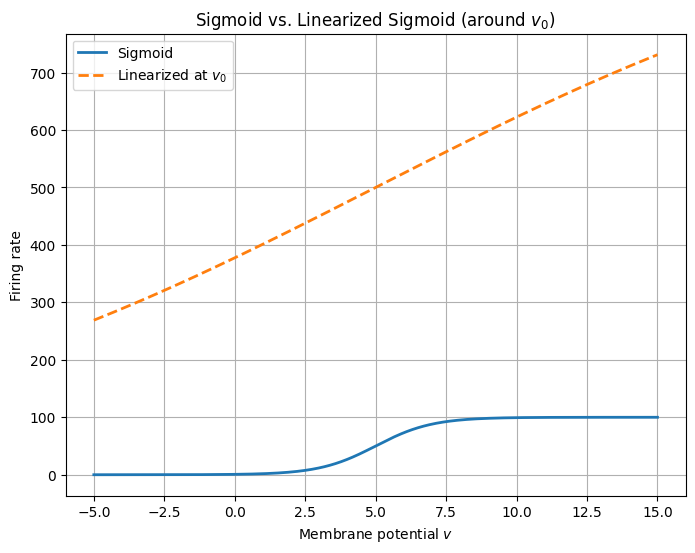

In [34]:
# Plot the results for comparison
plt.figure(figsize=(8, 6))
sigmoid_vals = sigmoid_pop(v_vals, pop='default', params=params)
plt.plot(v_vals, sigmoid_vals, label='Sigmoid', linewidth=2)
linear_vals = sigmoid_pop(v_vals, pop='default', params={
        'v0_default': 5.0,  # inflection point for 'default' population
        'v0_p2': 7.0,       # inflection point for 'P2' population
        'fmax': 1000.0,      # maximum firing rate
        'r_slope': 0.1      # slope parameter
    })
plt.plot(v_vals, linear_vals, '--', label='Linearized at $v_0$', linewidth=2)
plt.xlabel('Membrane potential $v$')
plt.ylabel('Firing rate')
plt.title('Sigmoid vs. Linearized Sigmoid (around $v_0$)')
plt.legend()
plt.grid(True)
plt.show()